# Introduction

In [324]:
# Import libraries

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Personalized unction library
from prepare_country_data import transpose_for_country_code, split_and_normalize, cyclical_transformation

# Prepare dataset

In [325]:
# Load complete dataset
df = pd.read_csv("data/2023/nordic_energy_data.csv")
# Apply transformations based on desired bidding zone
df_dk1 = transpose_for_country_code(df, "DK_1")
# Apply cyclical transformation to time
df_dk1 = cyclical_transformation(df_dk1)
# Chose desired time period
df_dk1['Timestamp'] = pd.to_datetime(df_dk1['Timestamp'])
#df_dk1 = df_dk1[(df_dk1['Timestamp'].dt.month >= 11) & (df_dk1['Timestamp'].dt.month <= 11)]
# Apply split and normalization based on desired number of test days
X_train, X_test, y_train, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std = split_and_normalize(df_dk1, test_days=14)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Convert to numpy arrays - relevant for some models
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()
y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()



X_train shape: (8400, 92)
X_test shape: (336, 92)
y_train shape: (8400,)
y_test shape: (336,)


# Temporal Model MMCA

In [326]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

from prepare_country_data import transpose_for_country_code

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [327]:
start_time_temporal = time.time()
x = pd.concat([X_train[2:], X_test])
y = pd.concat([y_train, y_test])
x = x.to_numpy()
y = y.to_numpy()
N,D = x.shape
T = len(y)
print("T=%d" % (T))
print("N=%d, D=%d" % (N,D))

y_true_std =y_train_std
y_true_mean = y_train_mean


ix_mis1 = np.arange(T - len(y_test), T)
ix_obs1 = np.arange(T - len(y_test))

T_mis = len(ix_mis1)
T_obs = len(ix_obs1)
T = T_obs + T_mis
print("T_obs:", T_obs)
print("T_mis:", T_mis)


T=8736
N=8734, D=92
T_obs: 8400
T_mis: 336


In [328]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    B1, B2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = B1*h_prev1 + B2*h_prev2 + jnp.matmul(W, x_t) + tau*noise_t
    h_prev1 = h_t
    h_prev2 = h_prev1
    
    return (B1,B2, W, h_prev1,h_prev2, tau), h_t

In [329]:
def model(T, T_forecast, x_t, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    B1 = numpyro.sample("B1", dist.Normal(loc=0., scale=1.))
    B2 = numpyro.sample("B2", dist.Normal(loc=0., scale=1.))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros(D), scale=jnp.ones(D)))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=.1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("z_1", dist.Normal(loc=0., scale=.1))
    h_prev2 = numpyro.sample("z_2", dist.Normal(loc=0., scale=.1))

    noises_t = numpyro.sample("noises_t", dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (B1,B2, W, h_prev1,h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    # Sample observed and missing values
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_mis", dist.Normal(loc=h_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_obs", dist.Normal(loc=h_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return h_collection

In [330]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=0, x_t=x, obs=y, ix_mis=ix_mis1, ix_obs=ix_obs1)

end_time_temporal = time.time()

minutes, seconds = divmod(end_time_temporal - start_time_temporal, 60)
print(f"Execution time for temporal model: {minutes:0.0f}m {seconds:0.0f}s")

sample: 100%|██████████| 2000/2000 [1:11:12<00:00,  2.14s/it, 1023 steps of size 1.28e-04. acc. prob=0.94]


Execution time for temporal model: 71m 14s


In [331]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
            B1     -0.48      0.37     -0.44     -1.10     -0.01      4.75      1.19
            B2      1.20      0.36      1.16      0.73      1.81      4.75      1.19
          W[0]      0.07      0.00      0.07      0.07      0.07      6.77      1.05
          W[1]      0.15      0.00      0.15      0.15      0.16      3.81      1.38
          W[2]     -0.03      0.01     -0.03     -0.04     -0.02      2.66      2.29
          W[3]     -0.06      0.00     -0.06     -0.06     -0.05      2.84      2.21
          W[4]     -0.15      0.00     -0.15     -0.16     -0.15      6.13      1.01
          W[5]      0.00      0.00      0.00      0.00      0.00      3.96      1.15
          W[6]      0.01      0.00      0.01      0.00      0.01      7.01      1.19
          W[7]      0.01      0.00      0.01      0.00      0.01      3.46      2.02
          W[8]      0.03      0.00      0.03      0.03      0.03

In [332]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


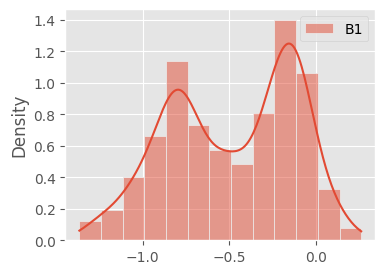

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


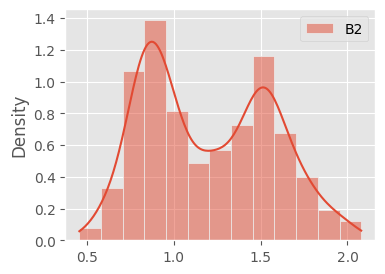

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


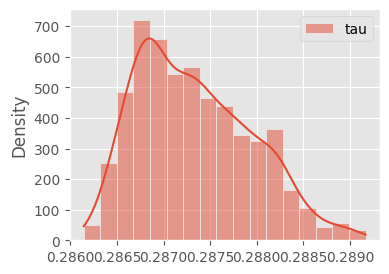

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


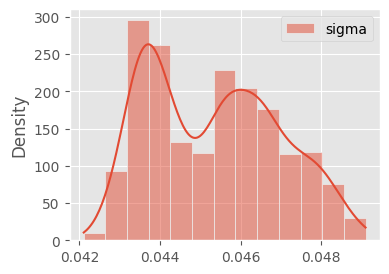

In [333]:
nodes = ["B1","B2", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()

In [334]:
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

In [335]:
predictions_temporal_MMCA = y_hat * y_true_std + y_true_mean

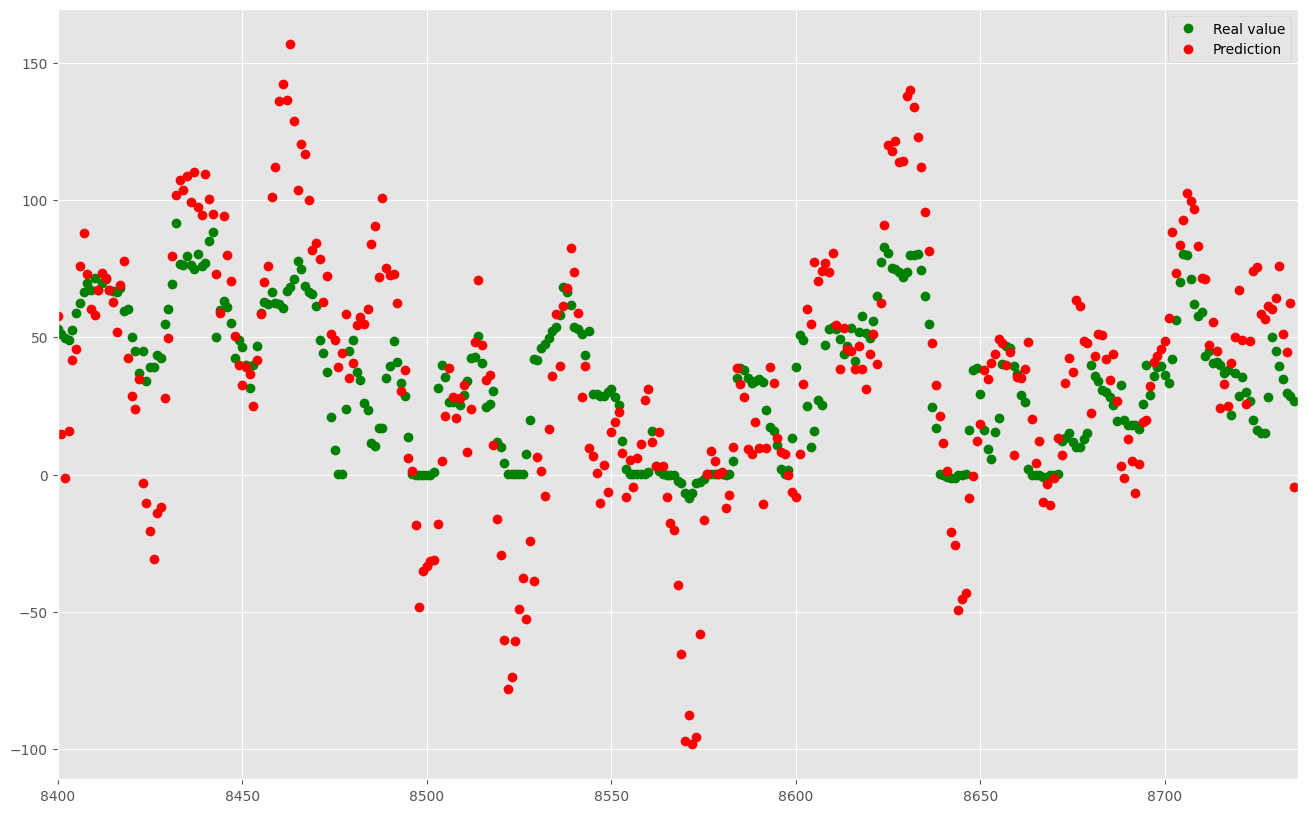

In [336]:
y_obs1 = y[ix_obs1]
y_mis1 = y[ix_mis1]

plt.plot(ix_mis1, (y_mis1*y_true_std) + y_true_mean, "go")
plt.plot(ix_mis1, (y_hat*y_true_std) + y_true_mean, "ro")
plt.xlim([T - len(y_test), T])
plt.legend(["Real value", "Prediction"])

In [337]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [338]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.738
MAE: 0.50572
RMSE: 0.65235
R2: 0.000


# Temporal Model SVI

# Simple Gaussian Model

In [339]:
# Define Covariance functions
def covSE(x1, x2, cov_params=[2.0]):
    return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))

def covPER(x1, x2, cov_params):
    return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))

def covWN(x1, x2, cov_params):
    if x1.any() == x2.any():
        return cov_params[0]
    else:
        return 0

def cov(x1, x2, cov_fn, cov_params):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i,j] = cov_fn(x1[i,:], x2[j,:], cov_params)
    return K

def covSUM_WN_SE(x1, x2, cov_params):
    K = covWN(x1, x2, cov_params[:1]) + covSE(x1, x2, cov_params[1:])
    return K

def covSUM_PER_SE(x1, x2, cov_params):
    return covPER(x1, x2, cov_params[:3]) + covSE(x1, x2, cov_params[3:])

def make_and_plot_cov(X, cov_func, cov_params):

    # construct K
    K = cov(X, X, cov_func, cov_params)
    plt.imshow(K)
    plt.title("Covariance matrix from Gaussian process prior")
    plt.show()
    return K

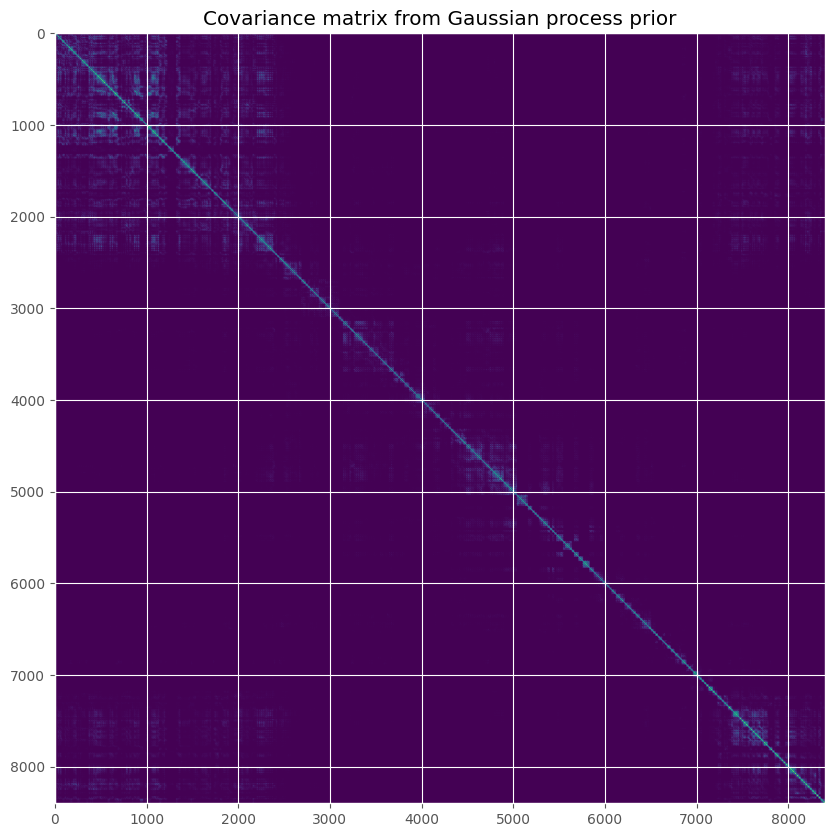

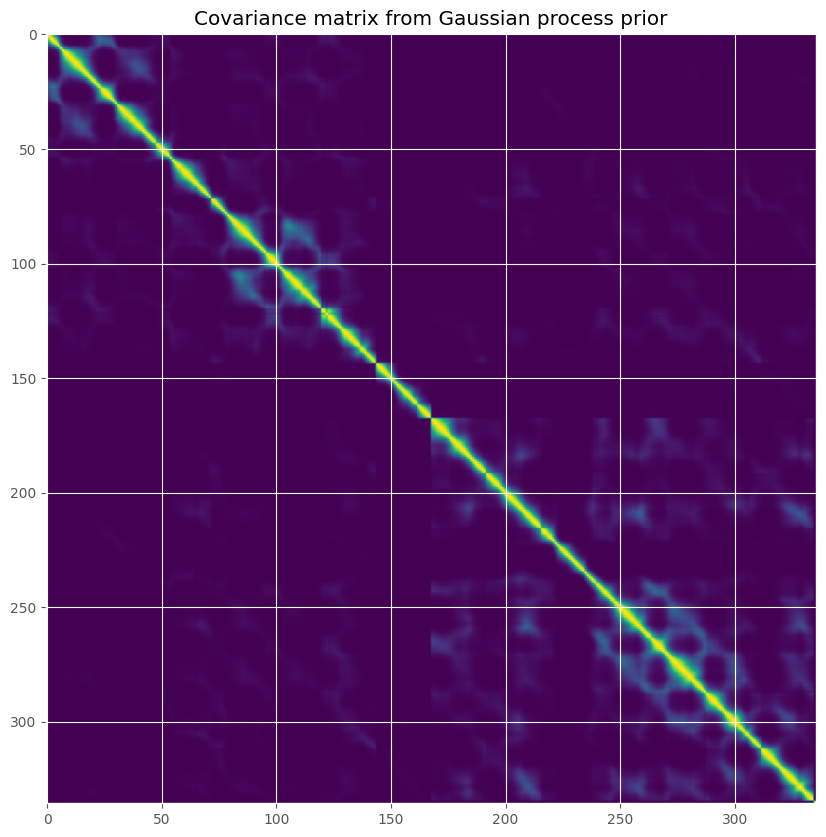

In [340]:
# Plot covariance matrices K and K_star_star
K = make_and_plot_cov(X_train_num, covSE, [0.05])
K = make_and_plot_cov(X_test_num, covSE, [0.1])

In [341]:
start_time_gp = time.time()
# Function to compute the predictive posterior
def compute_predictive_posterior(X_test_num, X_train_num, sigma, cov_params):
    N_test = len(X_test_num)

    predictions_gp = np.zeros(N_test)
    variances = np.zeros(N_test)
    
    K = cov(X_train_num, X_train_num, covSUM_PER_SE, cov_params)
    k_star = cov(X_train_num, X_test_num, covSUM_PER_SE, cov_params)
    k_star_star = cov(X_test_num, X_test_num, covSUM_PER_SE, cov_params)
    
    mean = k_star.T @ np.linalg.inv(sigma**2*np.eye(X_train_num.shape[0]) + K) @ y_train_num
    std = k_star_star + sigma**2 - k_star.T @ np.linalg.inv(sigma**2 * np.eye(X_train_num.shape[0]) + K) @ k_star

    predictions_gp =  np.random.multivariate_normal(mean.squeeze(), std)

    variances = np.diag(std)
    
    return predictions_gp, variances, mean, std, K

# Define parameters
cov_params = [1, 0.05, 2, 0.0001] # relatively good for PER_SE

sigma = 0.01
# Run model
predictions_gp, variances, mean, std, K = compute_predictive_posterior(X_test_num, X_train_num, sigma, cov_params)

end_time_gp = time.time()
minutes, seconds = divmod(end_time_gp - start_time_gp, 60)
print(f"Execution time for GP model: {minutes:0.0f}m {seconds:0.0f}s")

Execution time for GP model: 18m 46s


## Gaussian Model using sklearn-package

In [342]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, RBF
#cov_params = [1, 0.05, 2, 0.0001] # relatively good for PER_SE
start_time_gp_sk = time.time()
# Define the kernel
ESS_c = cov_params[0]
ESS_ls = cov_params[1]
ESS_per = cov_params[2]
rbf_c = 1
rbf_ls = cov_params[3]

kernel = ESS_c * ExpSineSquared(length_scale=ESS_ls, periodicity=ESS_per) + rbf_c * RBF(length_scale=rbf_ls)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process model
gp.fit(X_train_num, y_train_num)

# Make predictions on the test set
y_pred_GP_SK, y_std_GP_SK = gp.predict(X_test_num, return_std=True)

y_pred_GP_SK_back_tranformed = y_pred_GP_SK*y_train_std + y_train_mean

end_time_gp_sk = time.time()

minutes, seconds = divmod(end_time_gp_sk - start_time_gp_sk, 60)
print(f"Execution time for GP model with sklearn: {minutes:0.0f}m {seconds:0.0f}s")



Execution time for GP model with sklearn: 124m 50s


In [343]:
y_pred_GP_SK


array([-1.2603884 , -1.30036981, -1.3278553 , -1.29063143, -1.18752343,
       -0.95350409, -0.56125137, -0.21183738, -0.04104672, -0.09135628,
       -0.05900387, -0.14829528, -0.20465824, -0.25378265, -0.33758194,
       -0.42799493, -0.50102077, -0.54002248, -0.69692049, -0.79943338,
       -0.92092378, -0.96649152, -1.03120811, -1.00907063, -0.9978668 ,
       -1.07707433, -1.07720478, -0.98093529, -0.88991049, -0.7738163 ,
       -0.49632641, -0.08141525,  0.11823042,  0.18035601,  0.24347968,
        0.19152883,  0.07657008,  0.08533705,  0.02123552, -0.01803665,
        0.12068324,  0.16954512,  0.03337397, -0.30807553, -0.72932059,
       -0.91216862, -0.92833536, -0.96732092, -1.00641388, -1.17596125,
       -1.29351947, -1.42631516, -1.49103917, -1.48395984, -1.33135887,
       -1.0276893 , -0.79942215, -0.80312317, -0.70715333, -0.69965424,
       -0.65569232, -0.55199255, -0.43392983, -0.38586248, -0.16632764,
        0.03843959, -0.07023133, -0.2699709 , -0.3416091 , -0.47

In [344]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming compute_error is a function that returns the required metrics
corr_temporal, mae_temporal, rae_temporal, rmse_temporal, r2_temporal = compute_error(y_test_num, y_hat)
corr_GP_SK, mae_GP_SK, rae_GP_SK, rmse_GP_SK, r2_GP_SK = compute_error(y_test_num, y_pred_GP_SK)
corr_GP_own, mae_GP_own, rae_GP_own, rmse_GP_own, r2_GP_own = compute_error(y_test_num, predictions_gp)

# Create a table to display the error measures
import pandas as pd

data = {
    "Model": ["Temporal", "GP from scikit-learn", "Self-made GP"],
    "Correlation": [corr_temporal, corr_GP_SK, corr_GP_own],
    "MAE": [mae_temporal, mae_GP_SK, mae_GP_own],
    "RAE": [rae_temporal, rae_GP_SK, rae_GP_own],
    "RMSE": [rmse_temporal, rmse_GP_SK, rmse_GP_own],
    "R^2": [r2_temporal, r2_GP_SK, r2_GP_own]
}

df = pd.DataFrame(data)
print(df)

# Additionally, compute MSE for the GP models as in the initial code
mse_GP_SK = mean_squared_error(y_test_num, y_pred_GP_SK)
mse_GP_own = mean_squared_error(y_test_num, predictions_gp)

# Adding MSE to the DataFrame
df["MSE"] = [np.nan, mse_GP_SK, mse_GP_own]

print("\nError Measures Overview:")
print(df)

                  Model  Correlation       MAE       RAE      RMSE       R^2
0              Temporal     0.737580  0.505723  1.177024  0.652346  0.000000
1  GP from scikit-learn     0.813587  0.309542  0.720431  0.390186  0.420631
2          Self-made GP     0.389149  0.667418  1.553356  0.819880  0.000000

Error Measures Overview:
                  Model  Correlation       MAE       RAE      RMSE       R^2  \
0              Temporal     0.737580  0.505723  1.177024  0.652346  0.000000   
1  GP from scikit-learn     0.813587  0.309542  0.720431  0.390186  0.420631   
2          Self-made GP     0.389149  0.667418  1.553356  0.819880  0.000000   

        MSE  
0       NaN  
1  0.152245  
2  0.672202  


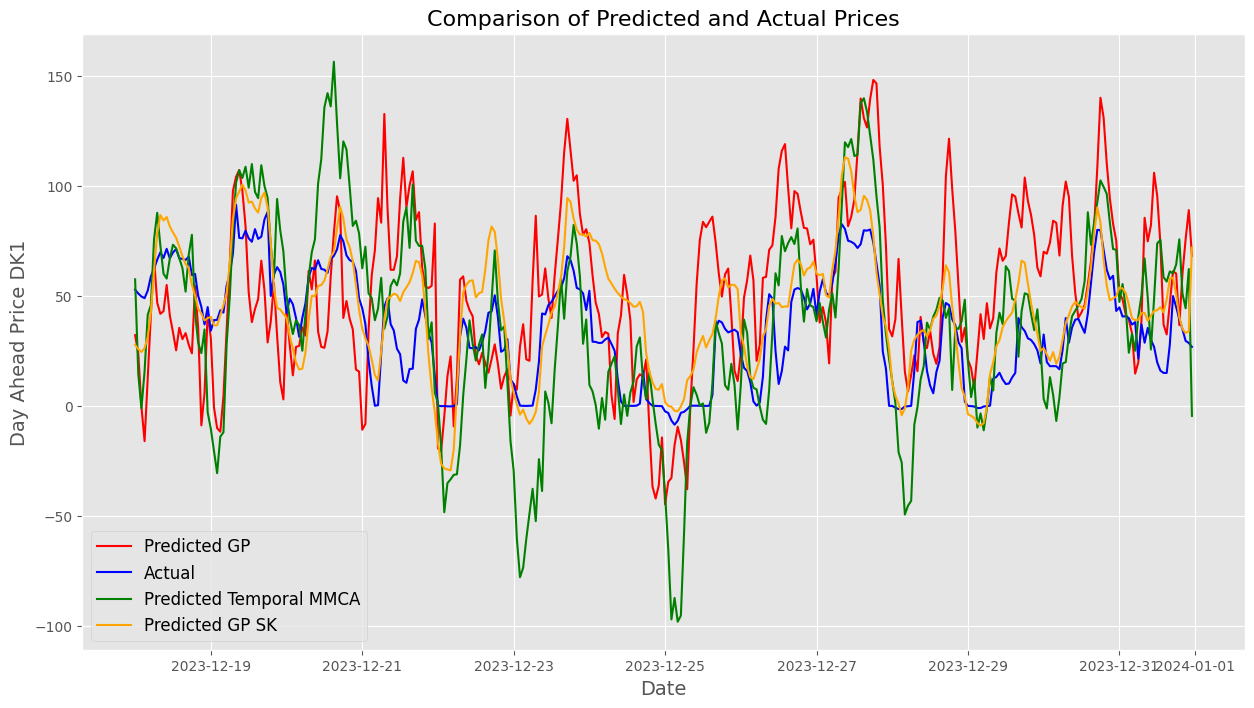

In [345]:


# Plot results
plt.figure(figsize=(15, 8))
predictions_gp_std = (predictions_gp * y_train_std) + y_train_mean
y_test_num_std = (y_test_num * y_train_std) + y_train_mean

plt.plot(y_test.index, predictions_gp_std, label="Predicted GP", color="red")
plt.plot(y_test.index, y_test_num_std, label="Actual", color="blue")
plt.plot(y_test.index, predictions_temporal_MMCA, label="Predicted Temporal MMCA", color="green")
plt.plot(y_test.index, y_pred_GP_SK_back_tranformed, label="Predicted GP SK", color="orange")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1", fontsize=14)
plt.title("Comparison of Predicted and Actual Prices", fontsize=16)
plt.legend(fontsize=12)
plt.show()


### Estimating the most important features

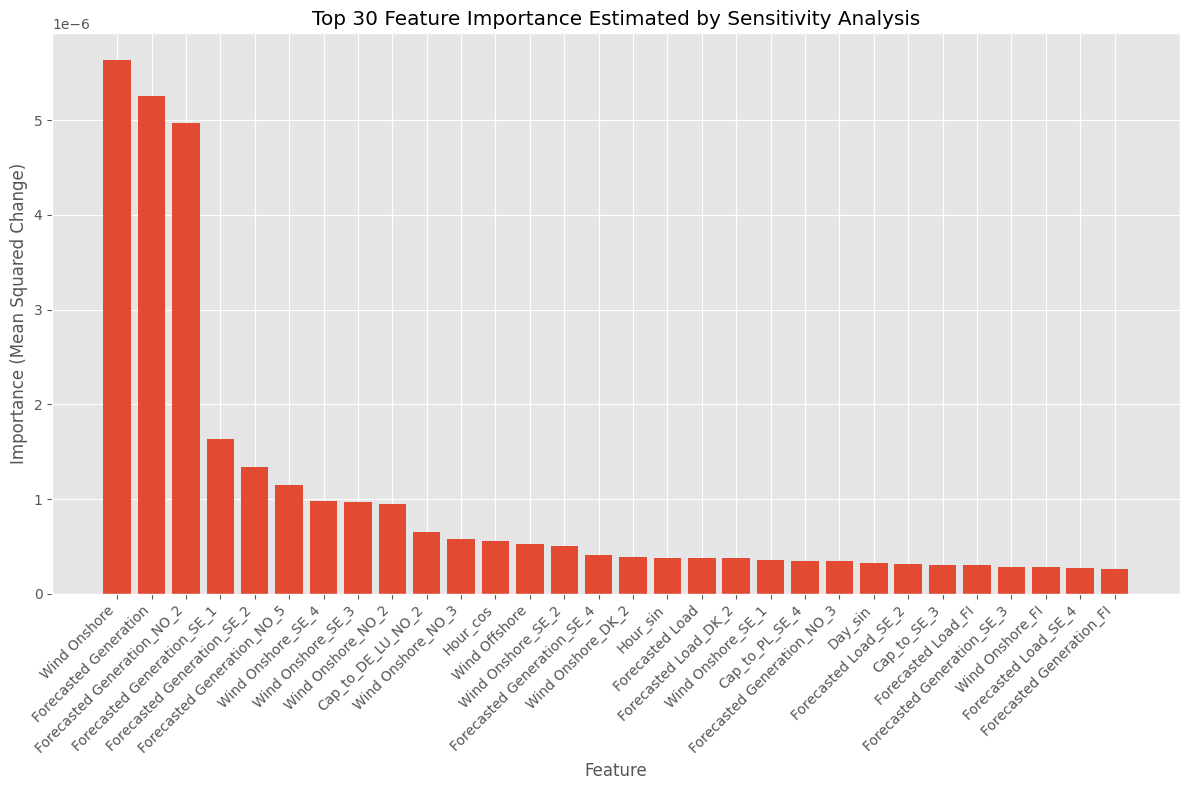

Execution time for sensitivity analysis: 1m 23s


In [346]:
# To provide insights into feature importance in a Gaussian Process (GP) model, 
# we can use a method that examines the sensitivity of the model's predictions to
# perturbations in each feature. This method can be understood as a local approximation
# of feature importance, and it involves observing how the predictions change as we
# slightly alter each feature while holding others constant. We'll apply small
# perturbations to each feature across the dataset and monitor the variance in the predictions.

#Here's how we can implement this:

#Choose a perturbation level (typically a small percentage of the feature's standard deviation).
#Perturb each feature one at a time in the test dataset, and observe the change in predictions.
#Calculate the mean squared change in predictions for each feature to estimate its relative importance.
start_time_sensitivity = time.time()
def feature_importance(gp, X, feature_names, epsilon=0.01):
    importances = np.zeros(X.shape[1])
    
    # Baseline prediction with original X
    baseline_pred = gp.predict(X)
    
    # Iterate over each feature
    for i in range(X.shape[1]):
        X_perturbed = np.copy(X)
        std_dev = np.std(X[:, i])
        
        # Perturb the feature
        X_perturbed[:, i] += epsilon * std_dev
        
        # Predict with perturbed data
        perturbed_pred = gp.predict(X_perturbed)
        
        # Calculate the mean squared difference
        importances[i] = np.mean((perturbed_pred - baseline_pred) ** 2)
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
    
    return sorted_importances, sorted_feature_names

# Feature names from the DataFrame
feature_names = X_train.columns.tolist()

# Calculate feature importances
sorted_importances, sorted_feature_names = feature_importance(gp, X_test_num, feature_names)

# Select the top 20 features
top_features = sorted_importances[:30]
top_feature_names = sorted_feature_names[:30]

# Plotting the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.bar(top_feature_names, top_features)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Feature')
plt.ylabel('Importance (Mean Squared Change)')
plt.title('Top 30 Feature Importance Estimated by Sensitivity Analysis')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

end_time_sensitivity = time.time()

minutes, seconds = divmod(end_time_sensitivity - start_time_sensitivity, 60)
print(f"Execution time for sensitivity analysis: {minutes:0.0f}m {seconds:0.0f}s")


# PPCA

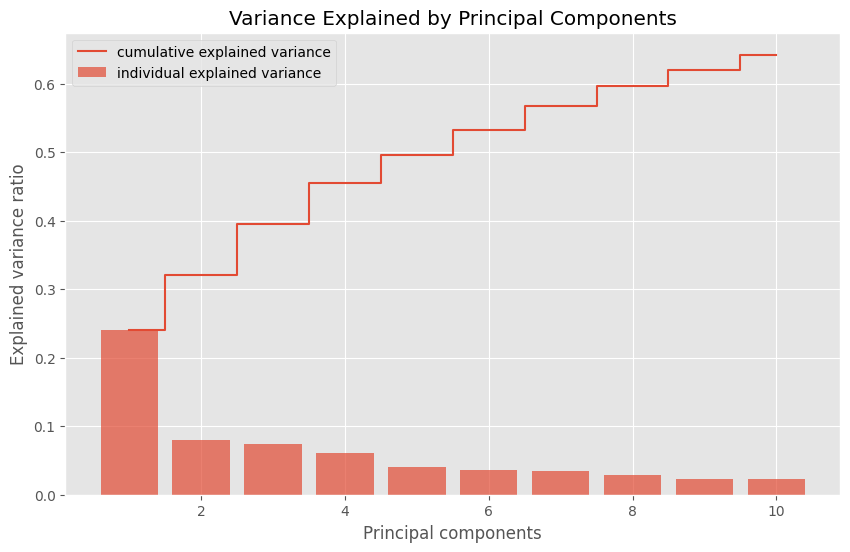

In [347]:
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from sklearn.decomposition import PCA

# Collect full data
X = pd.concat([X_train, X_test])
X = X.to_numpy()

# Make X torch for the Pyro model
X = torch.tensor(X, dtype=torch.float32)
y = pd.concat([y_train, y_test])

# Perform PCA
pca = PCA(n_components=10)
pca.fit(X)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_variance, alpha=0.7, align='center', label='individual explained variance')
plt.step(range(1, 11), np.cumsum(explained_variance), where='mid', label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.title('Variance Explained by Principal Components')
plt.legend(loc='best')
plt.show()

[0] ELBO: 1304518.0
[500] ELBO: 898213.0
[1000] ELBO: 889037.2
[1500] ELBO: 887356.1
[2000] ELBO: 886407.2
[2500] ELBO: 885579.8
[3000] ELBO: 884853.3
[3500] ELBO: 884242.4
[4000] ELBO: 883756.9
[4500] ELBO: 883283.9
[5000] ELBO: 882986.6
[5500] ELBO: 882722.1
[6000] ELBO: 882506.2
[6500] ELBO: 882278.4
[7000] ELBO: 882179.9
[7500] ELBO: 882097.5
[8000] ELBO: 882031.1
[8500] ELBO: 881987.1
[9000] ELBO: 881958.5
[9500] ELBO: 881922.8
[10000] ELBO: 881860.1
[10500] ELBO: 881878.6
[11000] ELBO: 881835.6
[11500] ELBO: 881844.8
z_mean.shape: (8736, 10)
w_mean.shape: (92, 10)
alpha_mean: [-1.2756428  -1.9480721  -1.3959575  -0.71459794 -1.9865898  -1.3859655
 -1.679119   -1.7133867  -1.8278445  -1.7401974 ]
Mean absolute error: 0.40
Root mean squared error: 0.60


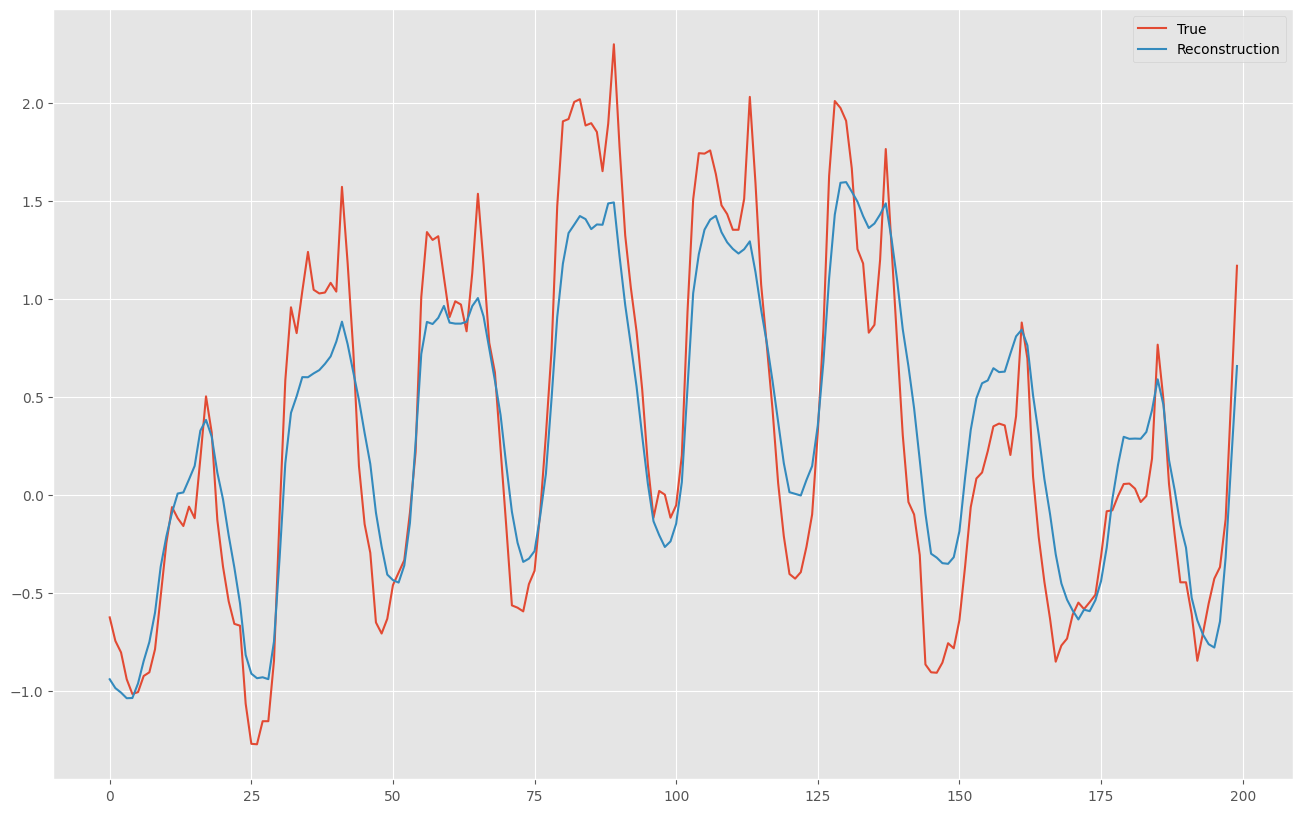

Execution time for constructing PCA: 14m 42s


In [348]:
start_time_pca = time.time()
def ppca_model_ard(X, latent_dim):
    input_dim = X.shape[1]
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    alpha = pyro.sample("alpha", dist.Gamma(1.0, 1.0).expand([latent_dim]).to_event(1))
    w = pyro.sample("w", dist.Normal(torch.zeros([input_dim, latent_dim]), alpha.unsqueeze(0).expand([input_dim, latent_dim])).to_event(2))
    
    with pyro.plate("data", len(X)) as ind:
        z = pyro.sample("z", dist.Normal(torch.zeros(latent_dim), 1).to_event(1))
        x = pyro.sample("x", dist.Normal(torch.matmul(z, w.T), sigma).to_event(1), obs=X[ind])
    
    return x

# Guide function
guide = AutoNormal(ppca_model_ard)

# Reset parameter values
pyro.clear_param_store()

# Define the number of latent dimensions
latent_dim = 10

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(ppca_model_ard, guide, optimizer, loss=elbo)

# Early stopping criteria
n_steps = 12000
#n_steps = 3000
early_stop_threshold = 1
early_stop_patience = 20
best_elbo = float('inf')
patience_counter = 0

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, latent_dim)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

    # Check for early stopping
    if step % 100 == 0:
        if best_elbo - elbo < early_stop_threshold:
            patience_counter += 1
        else:
            patience_counter = 0
            best_elbo = elbo
        
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at step {step} with ELBO: {elbo}")
            break

z_mean_ARD = pyro.get_param_store().get_param("AutoNormal.locs.z").detach().numpy()
w_mean_ARD = pyro.get_param_store().get_param("AutoNormal.locs.w").detach().numpy()
alpha_mean = pyro.get_param_store().get_param("AutoNormal.locs.alpha").detach().numpy()
print("z_mean.shape:", z_mean_ARD.shape)
print("w_mean.shape:", w_mean_ARD.shape)
print("alpha_mean:", alpha_mean)

reconstruction_ARD = np.matmul(z_mean_ARD, w_mean_ARD.T)

mae = torch.mean(torch.abs(X-reconstruction_ARD))
rmse = torch.sqrt(torch.mean((X-reconstruction_ARD)**2))
print("Mean absolute error: {:.2f}".format(mae))
print("Root mean squared error: {:.2f}".format(rmse))

#%% Plot first column in X and the reconstruction to see how well the model is doing. Only plot first 200 samples
plt.plot(X[:200,0], label="True")
plt.plot(reconstruction_ARD[:200,0], label="Reconstruction")
plt.legend()
plt.show()

end_time_pca = time.time()

minutes, seconds = divmod(end_time_pca - start_time_pca, 60)
print(f"Execution time for constructing PCA: {minutes:0.0f}m {seconds:0.0f}s")

In [349]:
len_z_mean = len(z_mean_ARD)
test_days = 14
test_size = (test_days * 24) / len_z_mean

# split the data into training and test set
Z_train_ARD, Z_test_ARD, _, _ = train_test_split(z_mean_ARD, y, test_size=test_size, shuffle=False)

# To numpy arrays
y_train_num = y_train.to_numpy().reshape(-1, 1)  # ravel() to convert y_train to 1D array
y_test_num = y_test.to_numpy().reshape(-1, 1)  # reshape(-1, 1) to convert y_test to 2D array

print(Z_train_ARD.shape)
print(Z_test_ARD.shape)
print(y_train_num.shape)
print(y_test_num.shape)

(8400, 10)
(336, 10)
(8400, 1)
(336, 1)


## Making GP with PPCA-data

In [350]:
start_time_gp_sk_ppca_ARD = time.time()

gp_PPCA_ARD = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process model
gp_PPCA_ARD.fit(Z_train_ARD, y_train_num)

# Make predictions on the test set
y_pred_GP_SK_PPCA_ARD, y_std_GP_SK_PPCA_ARD = gp_PPCA_ARD.predict(Z_test_ARD, return_std=True)

y_pred_GP_SK_back_tranformed_PPCA_ARD = y_pred_GP_SK_PPCA_ARD*y_train_std + y_train_mean

end_time_gp_sk_ppca_ARD = time.time()

minutes, seconds = divmod(end_time_gp_sk_ppca_ARD - start_time_gp_sk_ppca_ARD, 60)
print(f"Execution time for GP model with sklearn and PPCA: {minutes:0.0f}m {seconds:0.0f}s")

Execution time for GP model with sklearn and PPCA: 74m 40s


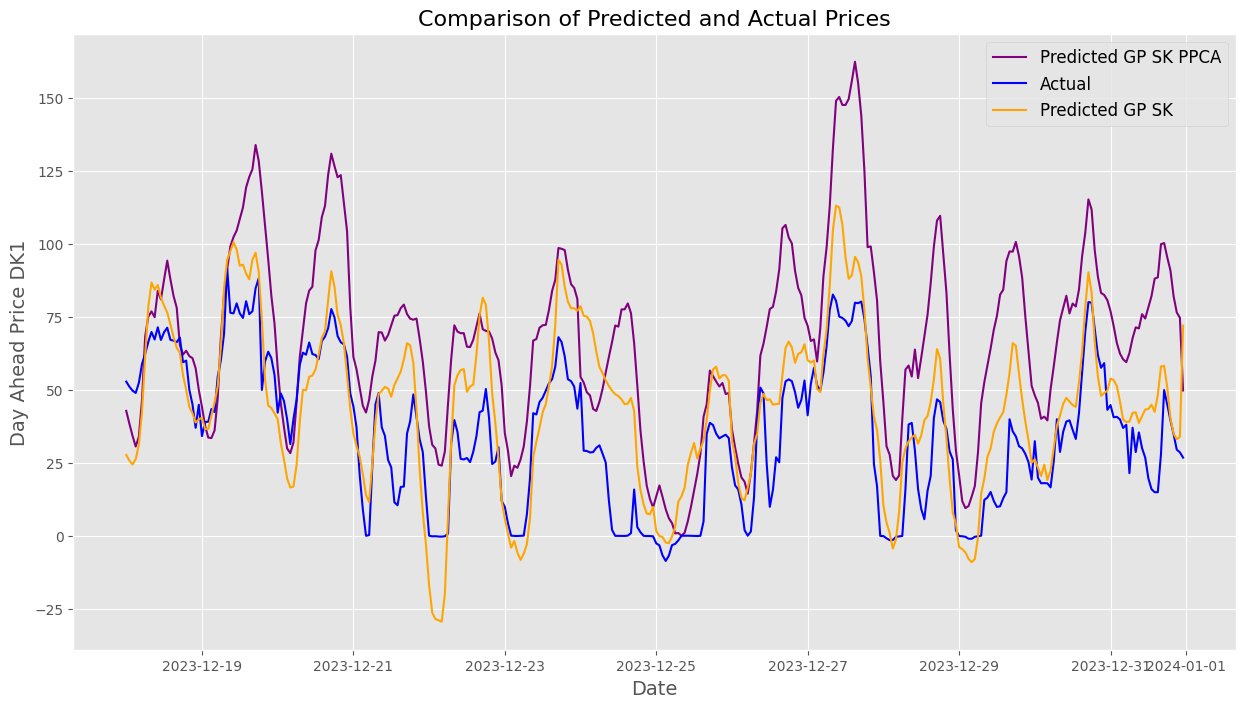

In [351]:
# Plot results
plt.figure(figsize=(15, 8))
plt.plot(y_test.index, y_pred_GP_SK_back_tranformed_PPCA_ARD, label="Predicted GP SK PPCA", color="purple")
plt.plot(y_test.index, y_test_num_std, label="Actual", color="blue")
plt.plot(y_test.index, y_pred_GP_SK_back_tranformed, label="Predicted GP SK", color="orange")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1", fontsize=14)
plt.title("Comparison of Predicted and Actual Prices", fontsize=16)
plt.legend(fontsize=12)
plt.show()

## Load predictions in csv-file

In [352]:
temporal_MMCA = pd.DataFrame(y_hat, columns=["Predicted Temporal MMCA"])
predictions_gp = pd.DataFrame(predictions_gp, columns=["Predicted GP"])
predictions_gp_sk = pd.DataFrame(y_pred_GP_SK, columns=["Predicted GP SK"])
predictions_gp_sk_ppca = pd.DataFrame(y_pred_GP_SK_PPCA_ARD, columns=["Predicted GP SK PPCA"])
# Save the predictions to a CSV file
predictions = pd.concat([temporal_MMCA, predictions_gp, predictions_gp_sk, predictions_gp_sk_ppca], axis=1)
predictions.to_csv("data/predictions.csv", index=False)

# Save Z_train and Z_test to a CSV file
z_mean_ARD = pd.DataFrame(z_mean_ARD)
z_mean_ARD.to_csv("data/z_mean_ARD.csv", index=False)

w_mean_ARD = pd.DataFrame(w_mean_ARD, columns=[f"W_{i}" for i in range(w_mean_ARD.shape[1])])
w_mean_ARD.to_csv("data/w_mean_ARD.csv", index=False)


